## Importing the required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Grayscale
from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\2335273961.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading and Preprocessing Image

torch.Size([300, 300, 3])

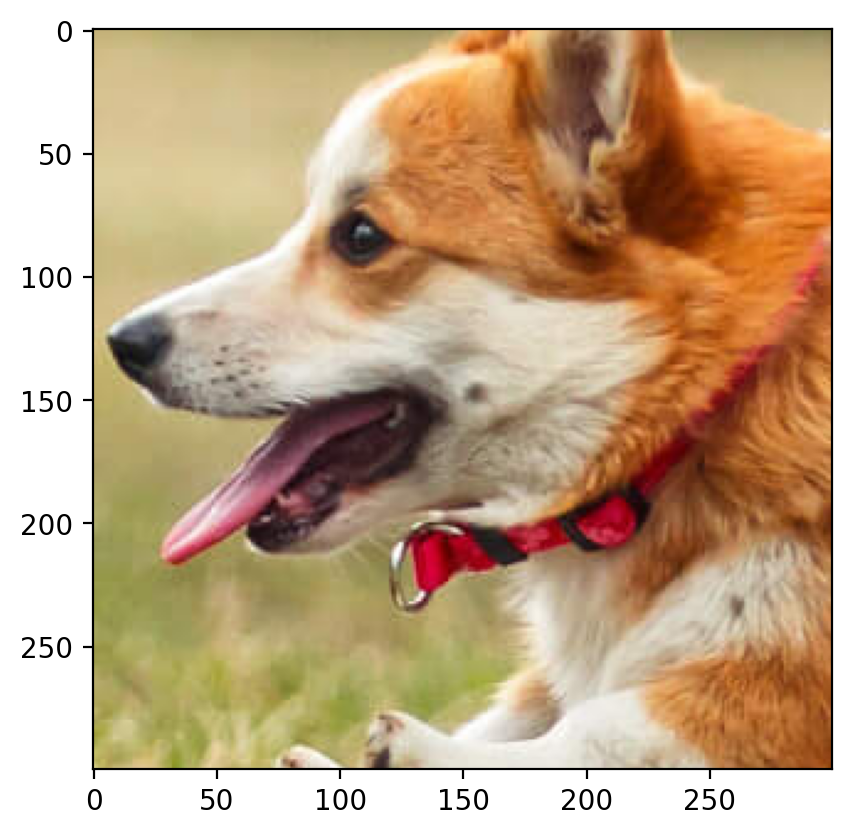

In [2]:
original_image = torchvision.io.read_image('dog.jpg')
cropped_image = torchvision.transforms.functional.crop(original_image,600,800,300,300)
cropped_image = rearrange(cropped_image,'c h w -> h w c')
plt.imshow(cropped_image)
cropped_image.shape

### Creating 3 patches with one color, two colors and multiple colors

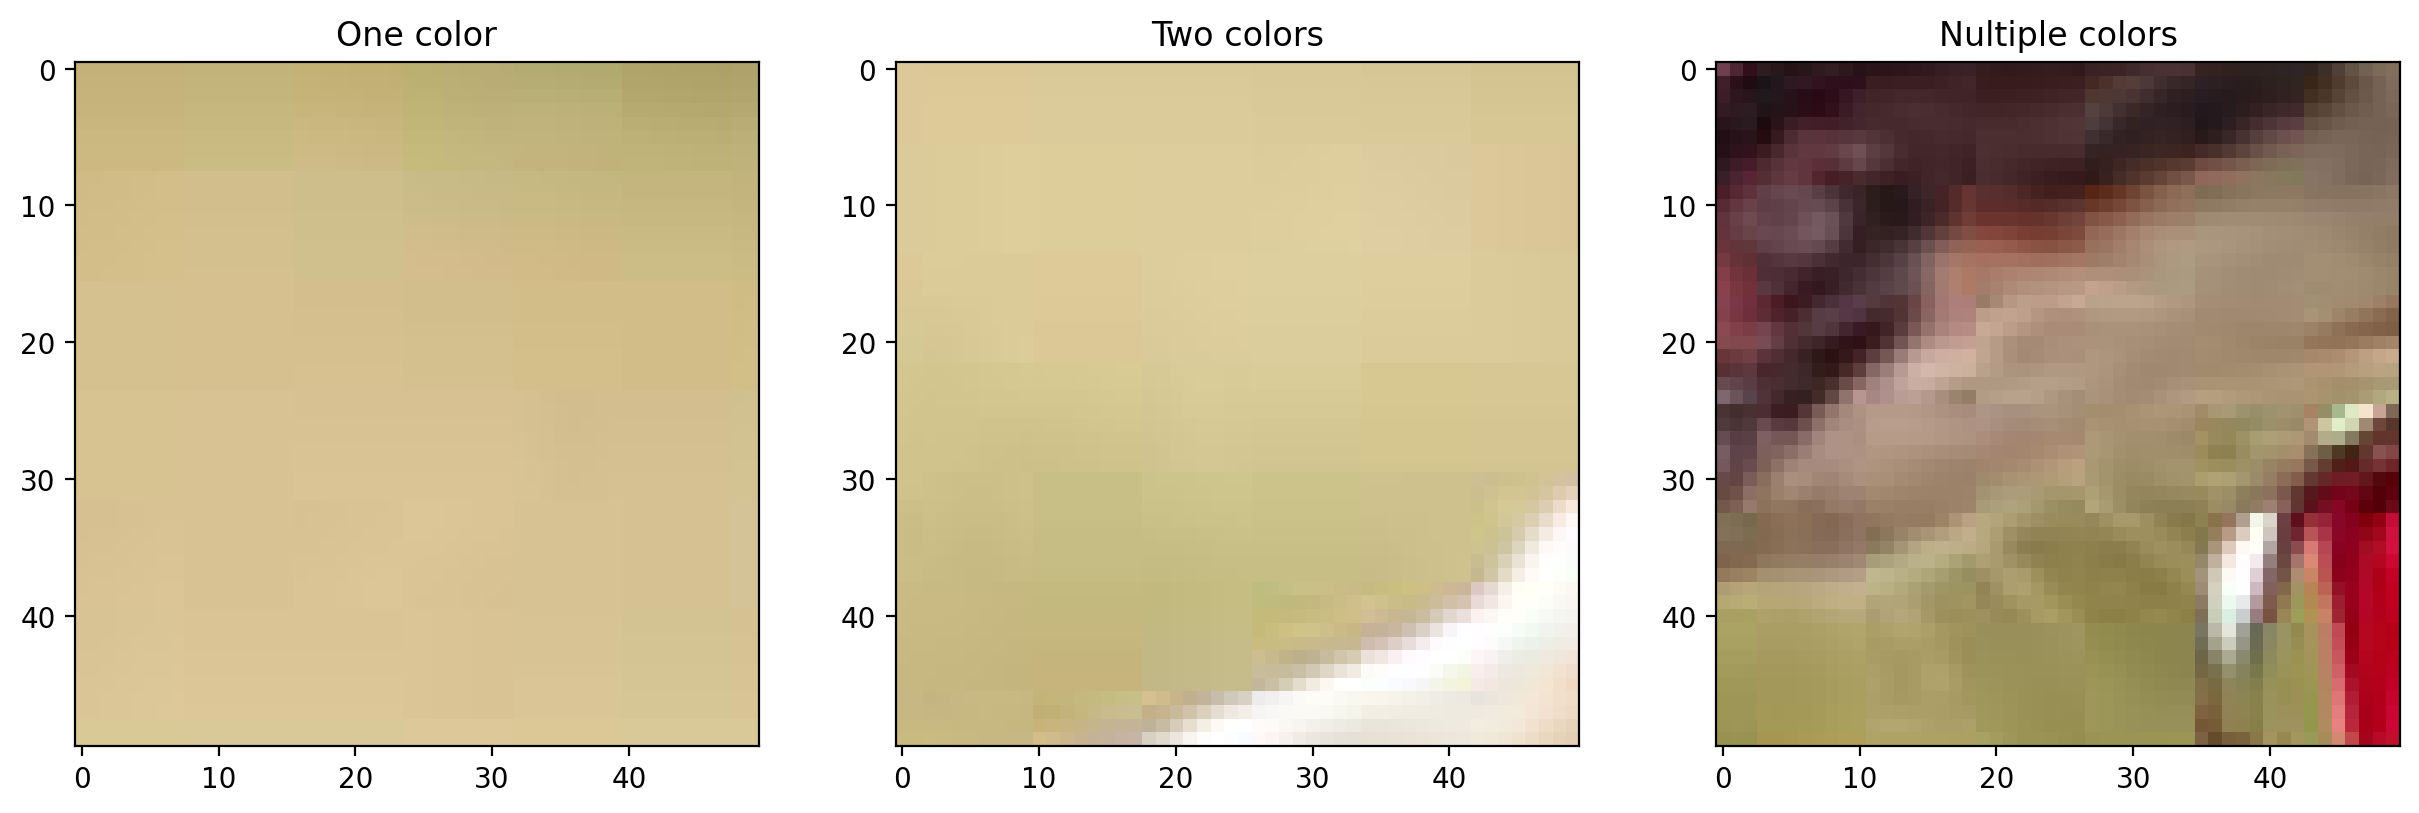

In [3]:
patch_1 = cropped_image[:50, :50]
patch_2 = cropped_image[50:100,30:80]
patch_3 = cropped_image[175:225,85:135]
ax, fig = plt.subplots(1,3, figsize=(15,15))
fig[0].imshow(patch_1)
fig[0].set_title('One color') 
fig[1].imshow(patch_2)
fig[1].set_title('Two colors')
fig[2].imshow(patch_3)
fig[2].set_title('Nultiple colors')
plt.show()


## Matrix Factorization

### Defining the metrics

In [4]:
def rmse(image1, image2):
    '''
    Function to return the root mean square error between two images
    Inputs:
    image1: First image
    image2: Second image

    Returns:
    rmse: Root mean square error between the two images
    '''
    image1 = image1.detach().cpu().numpy().astype(np.float64)
    image2 = image2.detach().cpu().numpy().astype(np.float64)
    return np.sqrt(np.mean((image1 - image2) ** 2))

def peak_snr(image1, image2):
    '''
    Function to return the peak signal to noise ratio between two images
    Inputs:
    image1: First image
    image2: Second image

    Returns:
    psnr: Peak signal to noise ratio between the two images
    '''
    image1 = image1.detach().cpu().numpy().astype(np.float64)
    image2 = image2.detach().cpu().numpy().astype(np.float64)
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr 


### Facorization Algorithm to Factorize image into two smaller rank matrices.

In [5]:
def factorize(A: torch.Tensor, k: int, epochs: int):
    '''
    Function to factorize an RGB image matrix A into two matrices W and H.
    The matrix A is of shape (m, n, 3) and the matrices W and H are of shape (m, k, 3) and (k, n, 3) respectively.

    Input:
    A: torch.Tensor: The matrix to be factorized (shape: m, n, 3)
    k: int: The rank of the factorization
    epochs: int: The number of epochs to train the model

    Returns:
    W: torch.Tensor: The matrix W of shape (m, k, 3)
    H: torch.Tensor: The matrix H of shape (k, n, 3)
    '''    
    m, n, c = A.shape  # Get dimensions of the input tensor
    W = torch.rand((m, k, c), requires_grad=True, device=device)
    H = torch.rand((k, n, c), requires_grad=True, device=device)
    A = A.to(device)
    
    optimizer = optim.Adam([W, H], lr=0.01)
    loss_arr = []
    print(f"Training for rank {k}")
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Compute A_hat for each channel separately
        A_hat = torch.zeros_like(A, device=device)
        for channel in range(c):
            A_hat[:, :, channel] = torch.matmul(W[:, :, channel], H[:, :, channel])
        
        loss = F.mse_loss(A_hat, A)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    print("--"*20)
    return W, H, loss_arr


### Function to Run the algorithm and Displaying Outputs for different ranks.

In [6]:
def get_data(patch_number:int, ranks: list, epochs: int, plot=True):
    '''
    Function to get the factorized matrices for different ranks

    Inputs:
    ranks: list: List of ranks to factorize the image into
    epochs: int: Number of epochs to train the model

    Returns:
    Ws: list: List of matrices W for each rank
    Hs: list: List of matrices H for each rank
    losses: list: List of loss arrays for each rank
    '''
    patch_mapping = {1: patch_1, 2: patch_2, 3: patch_3}
    Ws, Hs, losses = [], [], []
    for rank in ranks:
        W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)
        Ws.append(W)
        Hs.append(H)
        losses.append(loss_arr)
    # print(W,H, loss_arr)
    if (plot):
        x = np.arange(epochs)
        for i, rank in enumerate(ranks):
            plt.plot(x, losses[i], label=f'Rank {rank}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs Epochs')
        plt.show()
    RMSE = []
    PSNR = []
    for i in range(len(ranks)):
        factorized_params = [Ws[i], Hs[i]]
        print(Ws[i].shape, Hs[i].shape) 
        channel_1 = torch.matmul(factorized_params[0][:, :, 0], factorized_params[1][:, :, 0])
        channel_2 = torch.matmul(factorized_params[0][:, :, 1], factorized_params[1][:, :, 1])
        channel_3 = torch.matmul(factorized_params[0][:, :, 2], factorized_params[1][:, :, 2])
        reconstructed_image = torch.stack([channel_1, channel_2, channel_3])
        reconstructed_image = torch.clamp(reconstructed_image, 0, 255)
        RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
        PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
        copy = cropped_image.detach().clone().cpu().numpy()
        if patch_number==1:
            copy[:50, :50] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        elif patch_number==2:
            copy[50:100,30:80] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        else:
            copy[175:225,85:135] = reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        fig,ax = plt.subplots(1,4, figsize=(15,15))
        ax[0].imshow(patch_mapping[patch_number])
        ax[0].set_title('Original Patch')
        ax[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
        ax[1].set_title(f'Reconstructed Patch Rank = {ranks[i]}')
        ax[2].imshow(cropped_image)
        ax[2].set_title('Original Image')
        ax[3].imshow(copy)
        ax[3].set_title(f'Reconstructed Image Rank = {ranks[i]}')
        plt.show()
    return Ws, Hs, losses, RMSE, PSNR

## Patch 1 - Single Colored Patch

C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)


Training for rank 5
Epoch 1/1000, Loss: 33045.4765625
Epoch 101/1000, Loss: 28557.734375
Epoch 201/1000, Loss: 18595.033203125
Epoch 301/1000, Loss: 8165.12744140625
Epoch 401/1000, Loss: 2192.21142578125
Epoch 501/1000, Loss: 348.3096008300781
Epoch 601/1000, Loss: 41.40625762939453
Epoch 701/1000, Loss: 8.934760093688965
Epoch 801/1000, Loss: 5.590559482574463
Epoch 901/1000, Loss: 5.120466709136963
----------------------------------------
Training for rank 10
Epoch 1/1000, Loss: 32648.099609375
Epoch 101/1000, Loss: 24266.15625
Epoch 201/1000, Loss: 9532.138671875
Epoch 301/1000, Loss: 1404.4461669921875
Epoch 401/1000, Loss: 73.94185638427734
Epoch 501/1000, Loss: 7.759010314941406
Epoch 601/1000, Loss: 5.2443318367004395
Epoch 701/1000, Loss: 5.064572811126709
Epoch 801/1000, Loss: 5.049692630767822
Epoch 901/1000, Loss: 5.046489715576172
----------------------------------------
Training for rank 25
Epoch 1/1000, Loss: 31273.169921875
Epoch 101/1000, Loss: 13796.236328125
Epoch 20

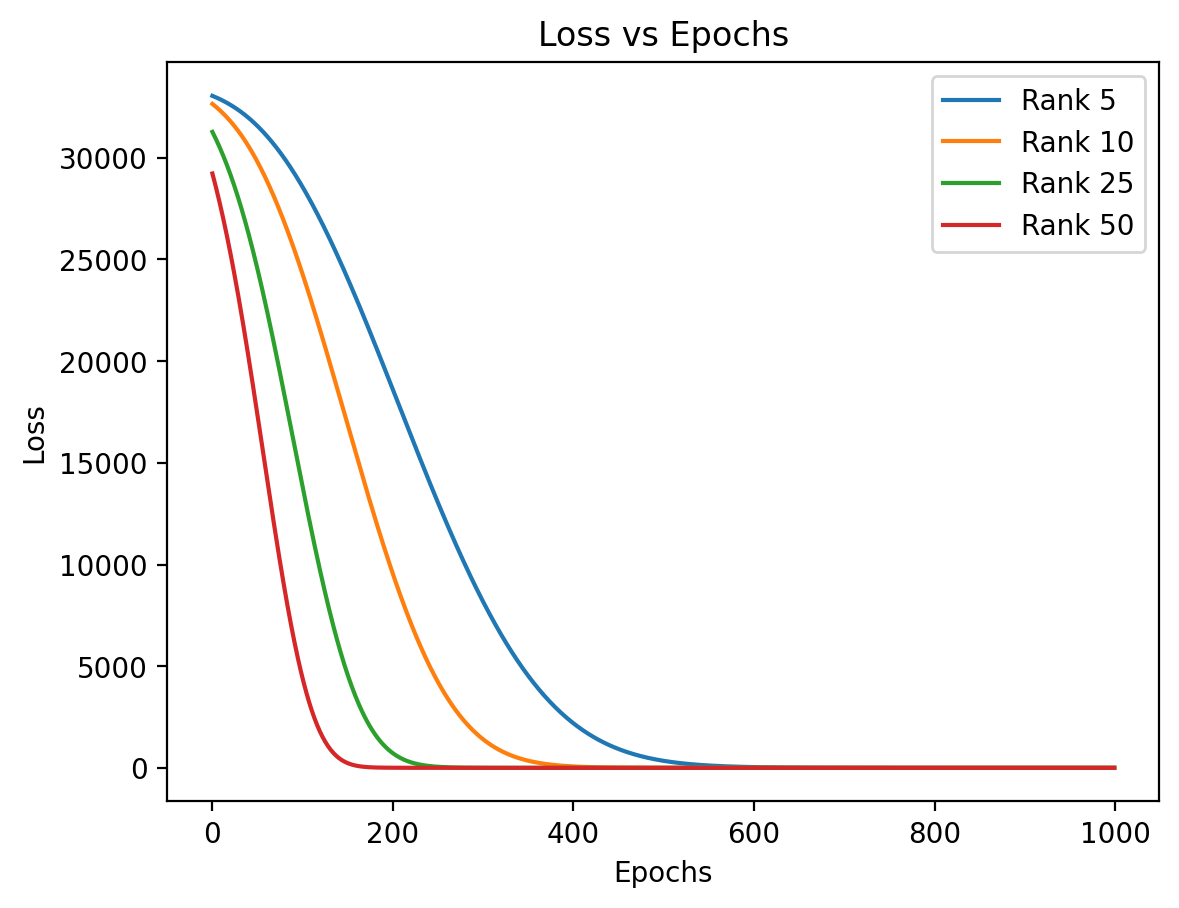

torch.Size([50, 5, 3]) torch.Size([5, 50, 3])


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))


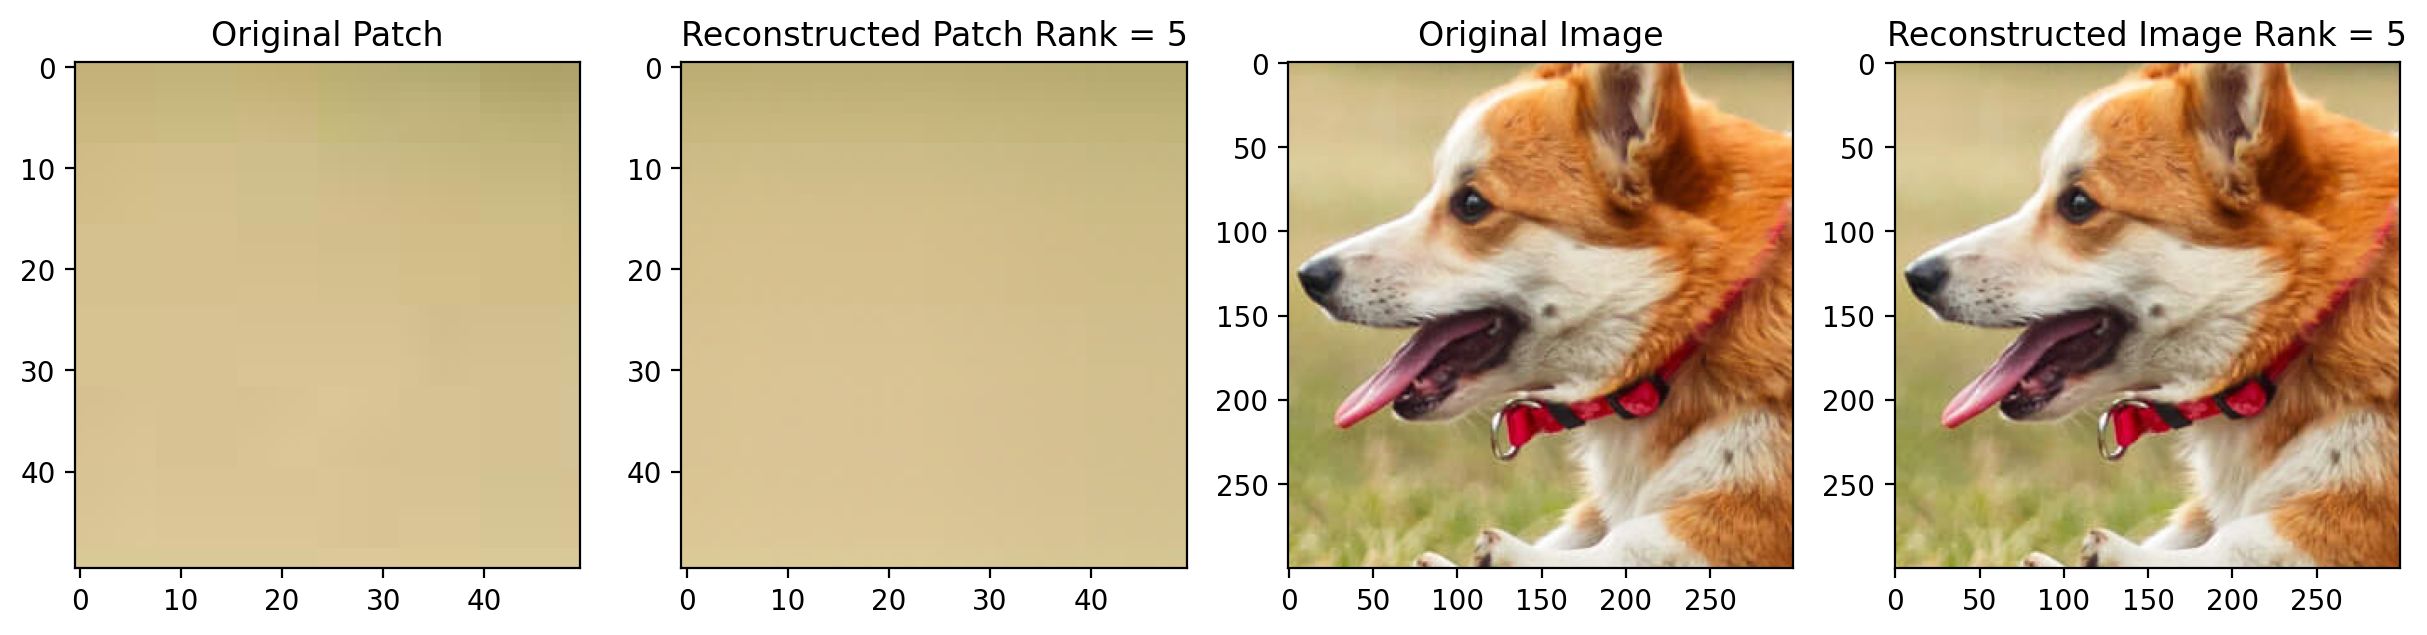

torch.Size([50, 10, 3]) torch.Size([10, 50, 3])


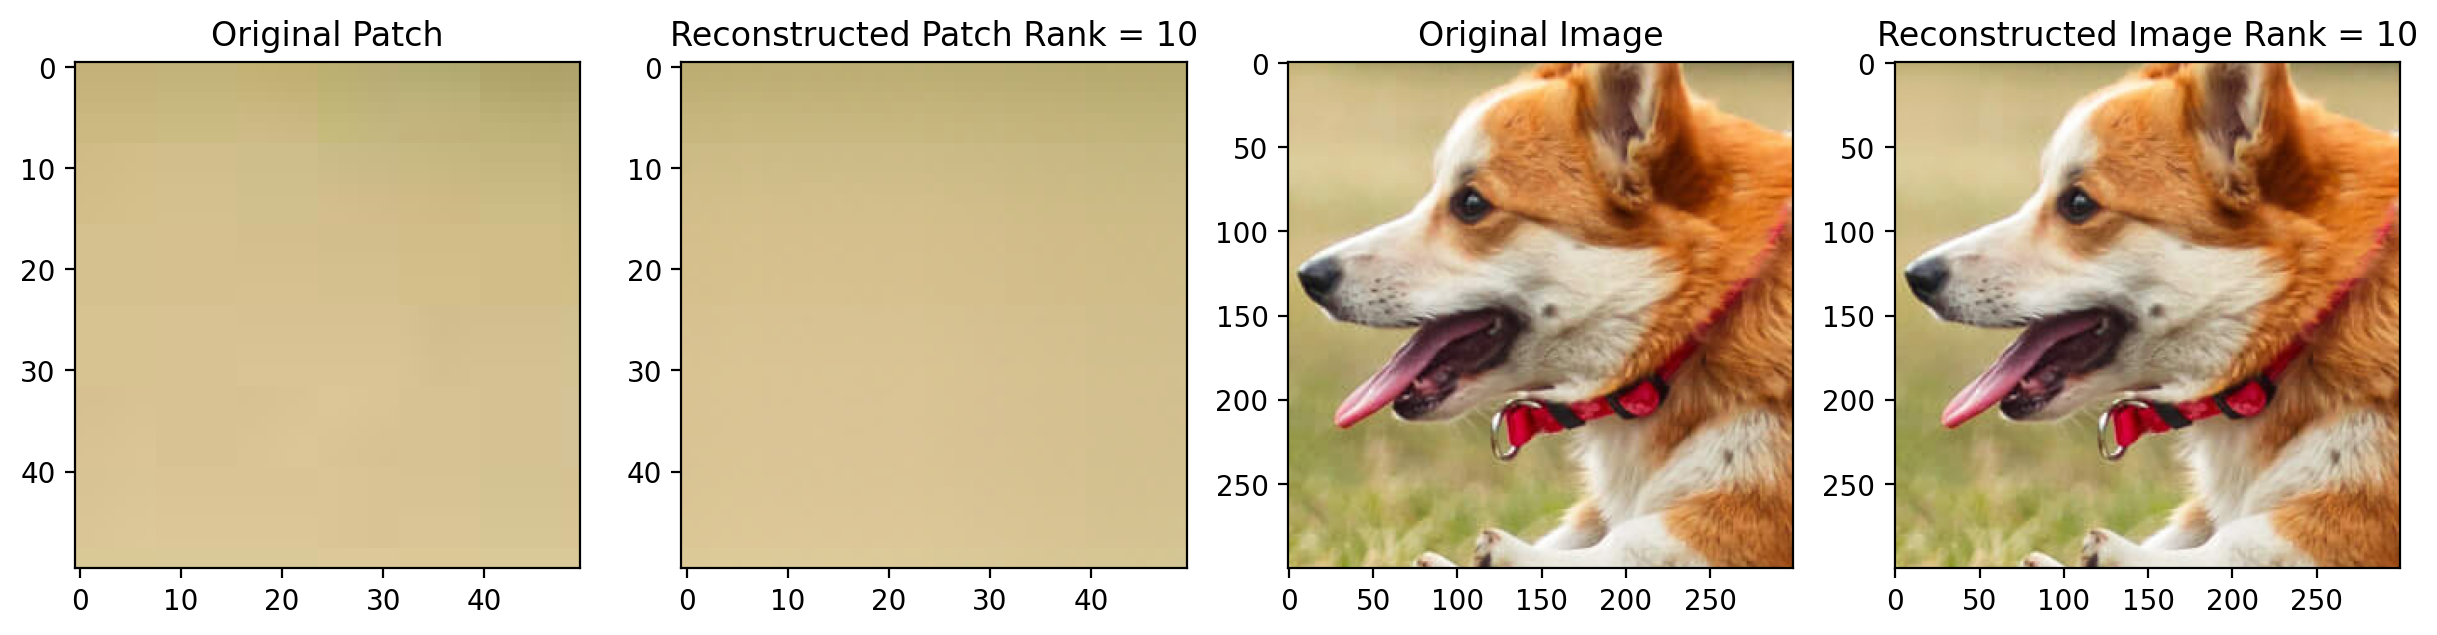

torch.Size([50, 25, 3]) torch.Size([25, 50, 3])


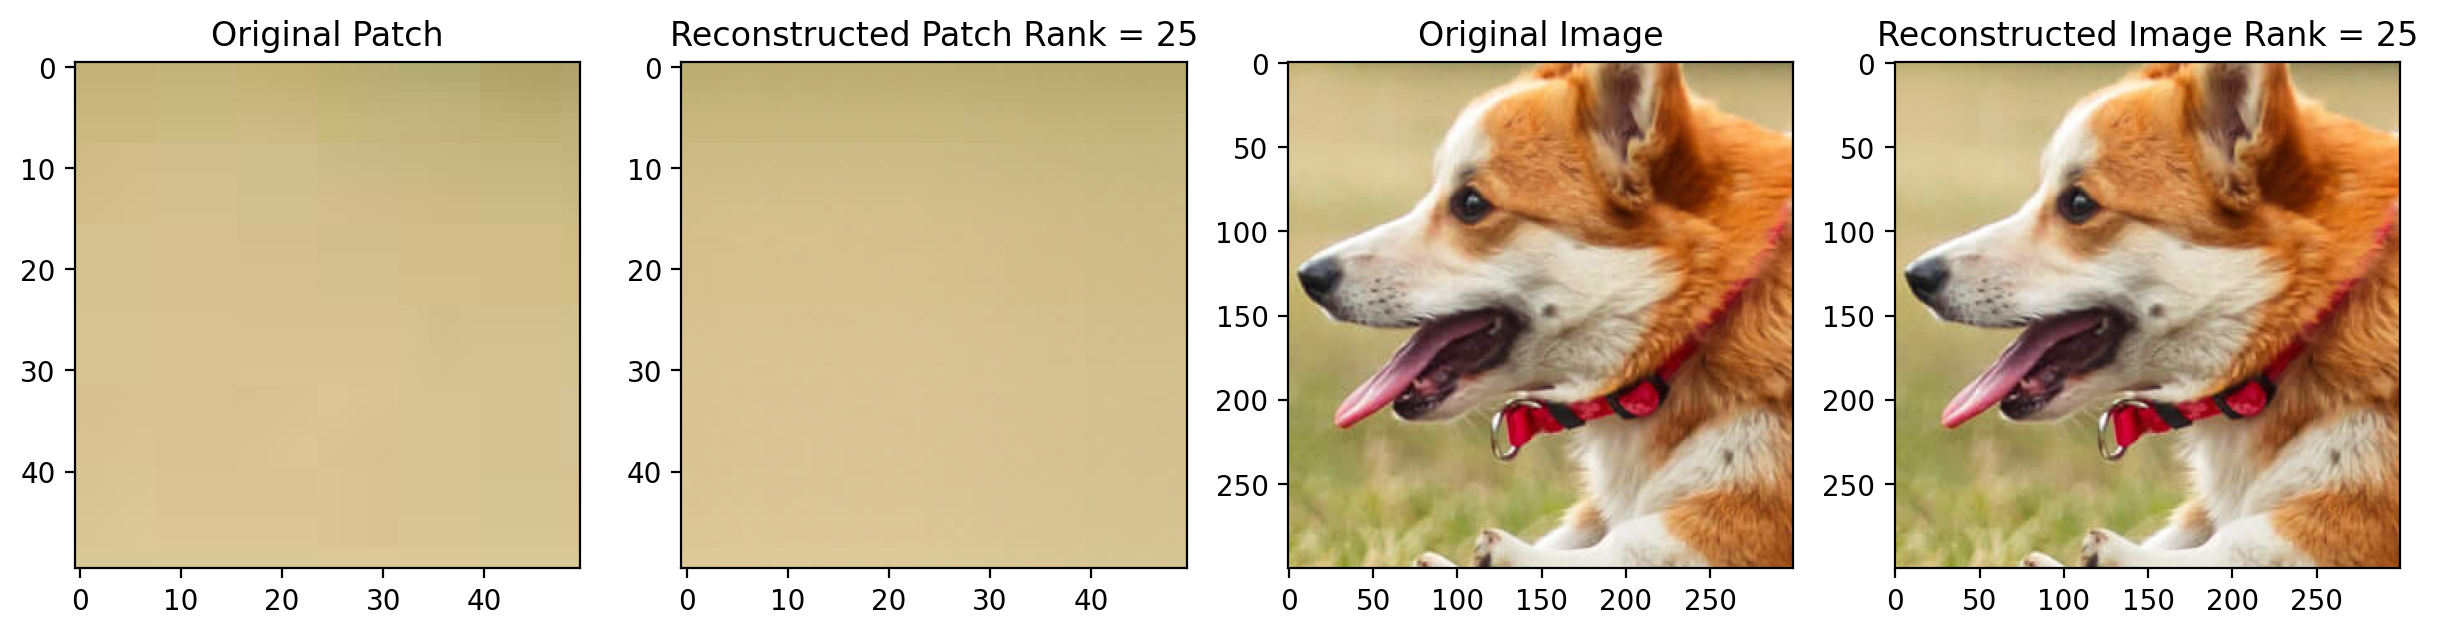

torch.Size([50, 50, 3]) torch.Size([50, 50, 3])


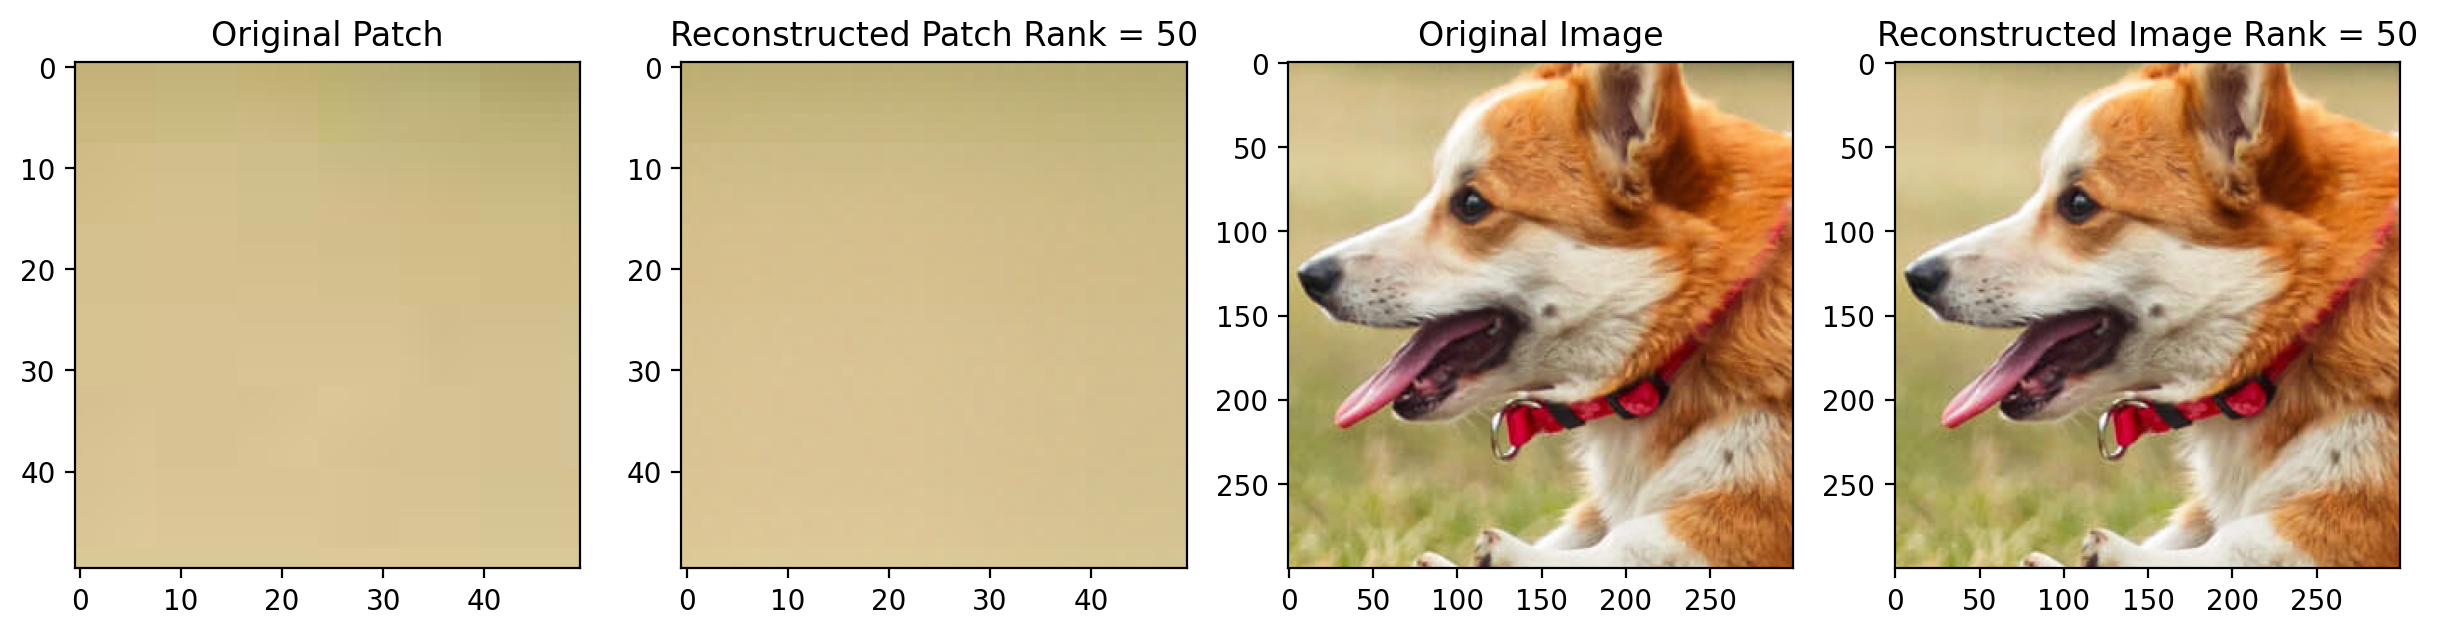

In [7]:
ranks = [5,10,25,50]
params_patch_1 = get_data(1, [5,10,25,50], 1000)

In [8]:
RMSE, PSNR = params_patch_1[3], params_patch_1[4]
for i in range(len(ranks)):
    print(f'Rank: {ranks[i]}, RMSE: {RMSE[i]}, PSNR: {PSNR[i]}')

Rank: 5, RMSE: 2.2459577489359748, PSNR: 41.10277196800251
Rank: 10, RMSE: 2.2458237663866205, PSNR: 41.10329013997213
Rank: 25, RMSE: 2.2584054352968095, PSNR: 41.05476540157514
Rank: 50, RMSE: 2.2216017830327868, PSNR: 41.197479302634235


## Patch 2 - Two Colored Patch

Training for rank 5
Epoch 1/2000, Loss: 36720.1796875
Epoch 101/2000, Loss: 32002.126953125
Epoch 201/2000, Loss: 21350.96875


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)


Epoch 301/2000, Loss: 9876.09765625
Epoch 401/2000, Loss: 2982.144775390625
Epoch 501/2000, Loss: 712.0277709960938
Epoch 601/2000, Loss: 299.0030212402344
Epoch 701/2000, Loss: 248.02023315429688
Epoch 801/2000, Loss: 241.1431884765625
Epoch 901/2000, Loss: 239.86083984375
Epoch 1001/2000, Loss: 239.5840301513672
Epoch 1101/2000, Loss: 239.50253295898438
Epoch 1201/2000, Loss: 239.44891357421875
Epoch 1301/2000, Loss: 239.3888702392578
Epoch 1401/2000, Loss: 239.3123016357422
Epoch 1501/2000, Loss: 239.21090698242188
Epoch 1601/2000, Loss: 239.07290649414062
Epoch 1701/2000, Loss: 238.88031005859375
Epoch 1801/2000, Loss: 238.60458374023438
Epoch 1901/2000, Loss: 238.2001495361328
----------------------------------------
Training for rank 10
Epoch 1/2000, Loss: 36215.8671875
Epoch 101/2000, Loss: 27245.697265625
Epoch 201/2000, Loss: 11296.5859375
Epoch 301/2000, Loss: 2010.0609130859375
Epoch 401/2000, Loss: 343.3770751953125
Epoch 501/2000, Loss: 245.35243225097656
Epoch 601/2000, L

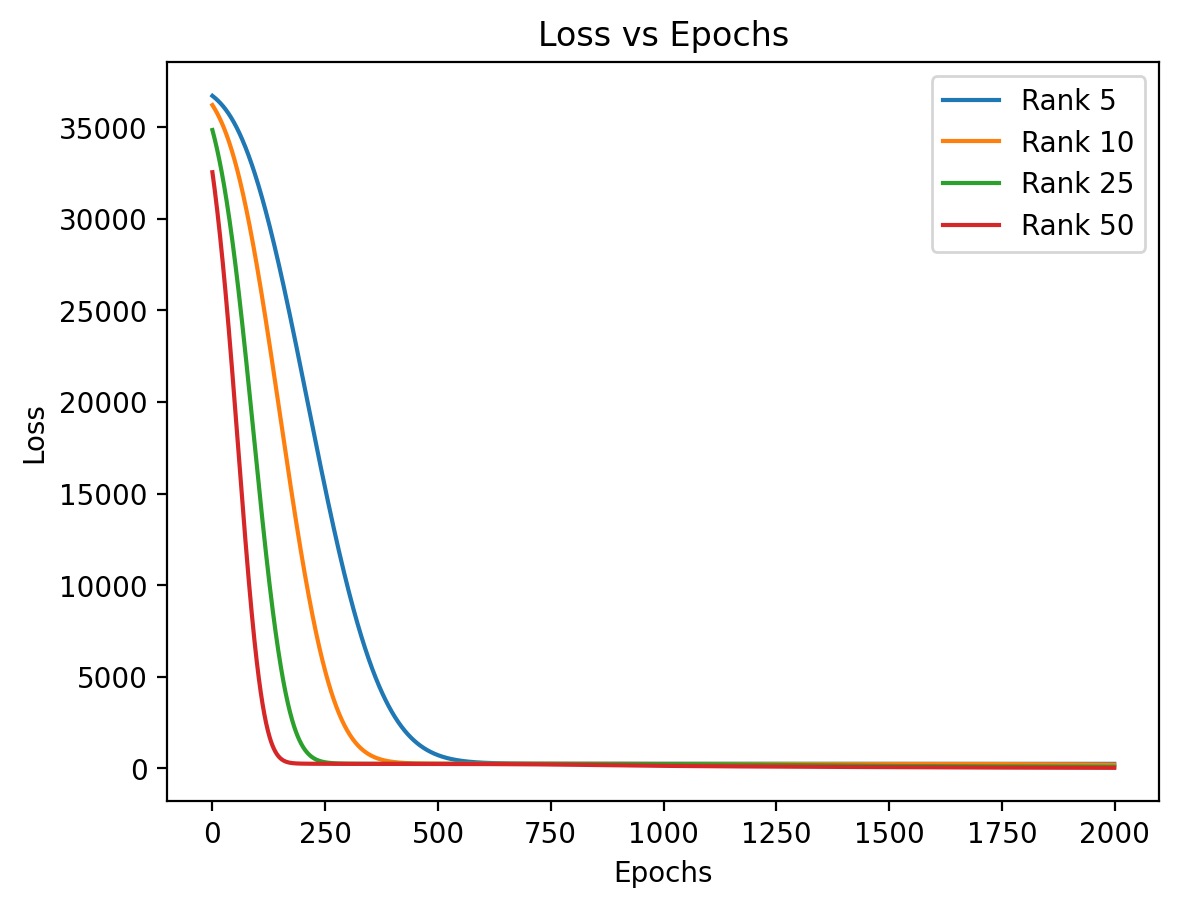

torch.Size([50, 5, 3]) torch.Size([5, 50, 3])


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))


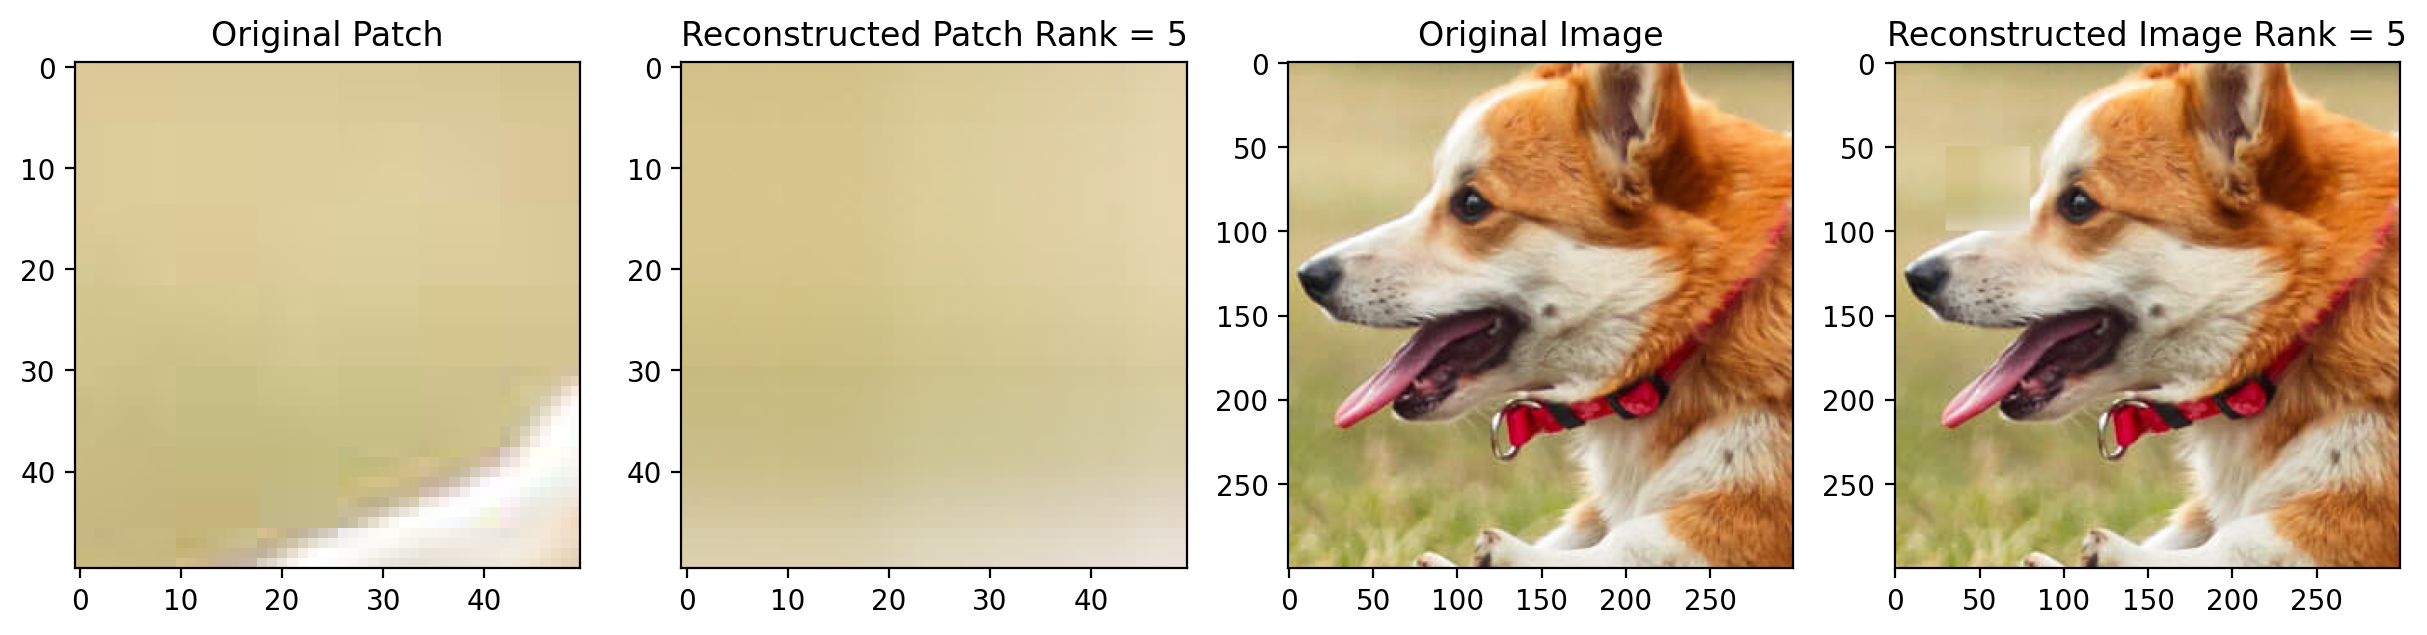

torch.Size([50, 10, 3]) torch.Size([10, 50, 3])


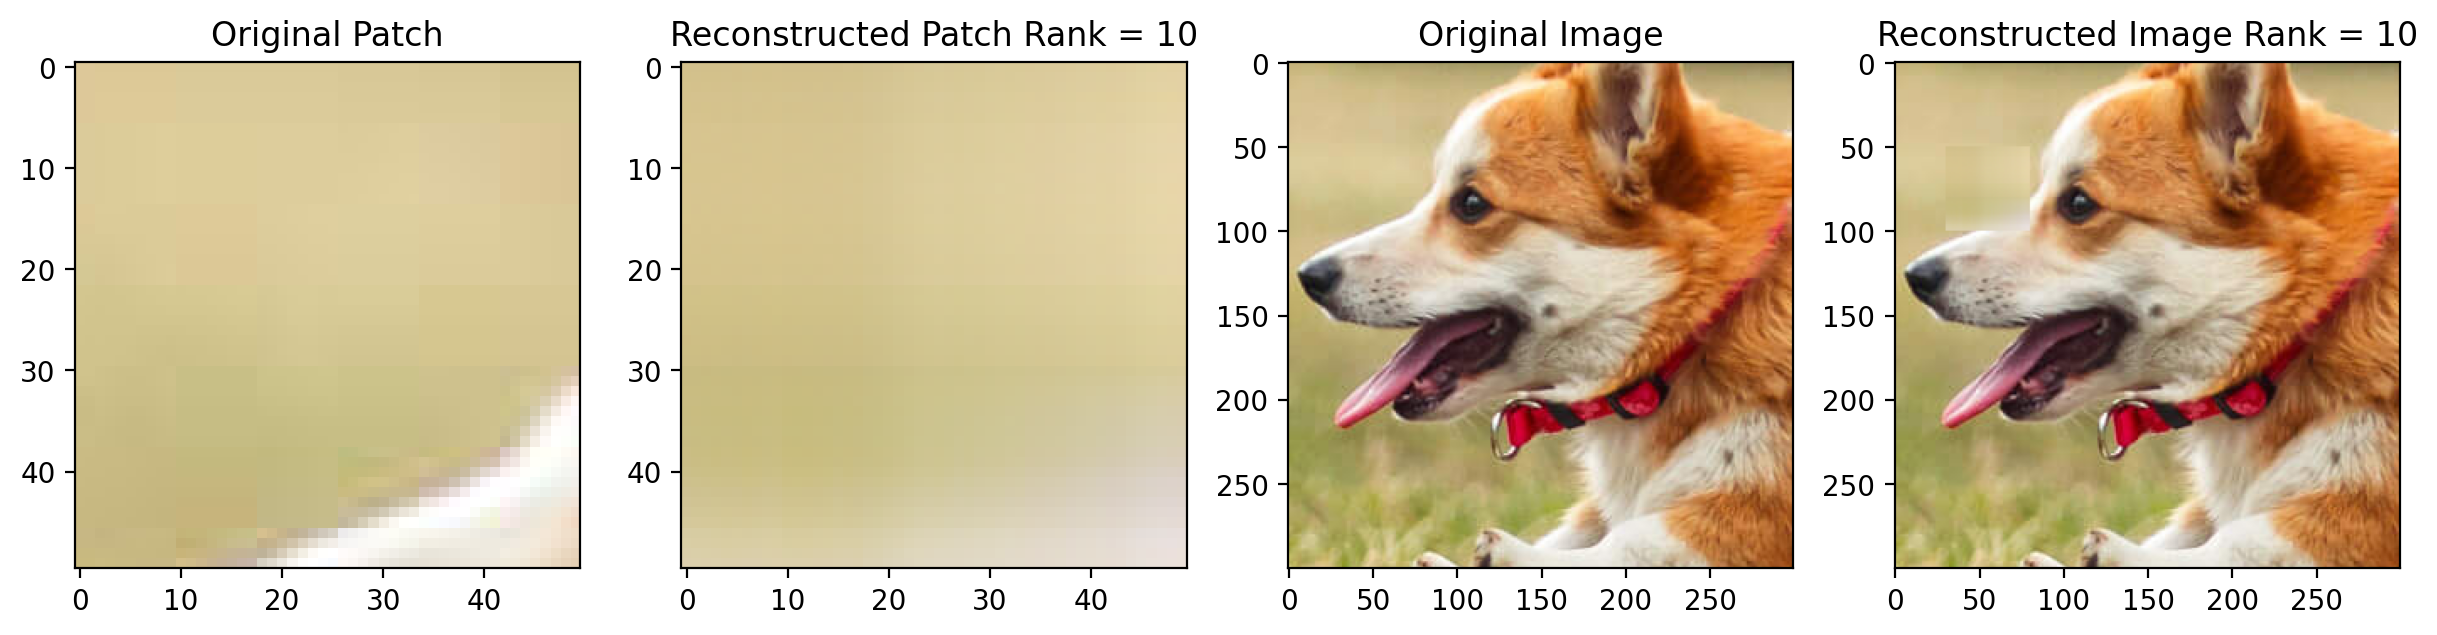

torch.Size([50, 25, 3]) torch.Size([25, 50, 3])


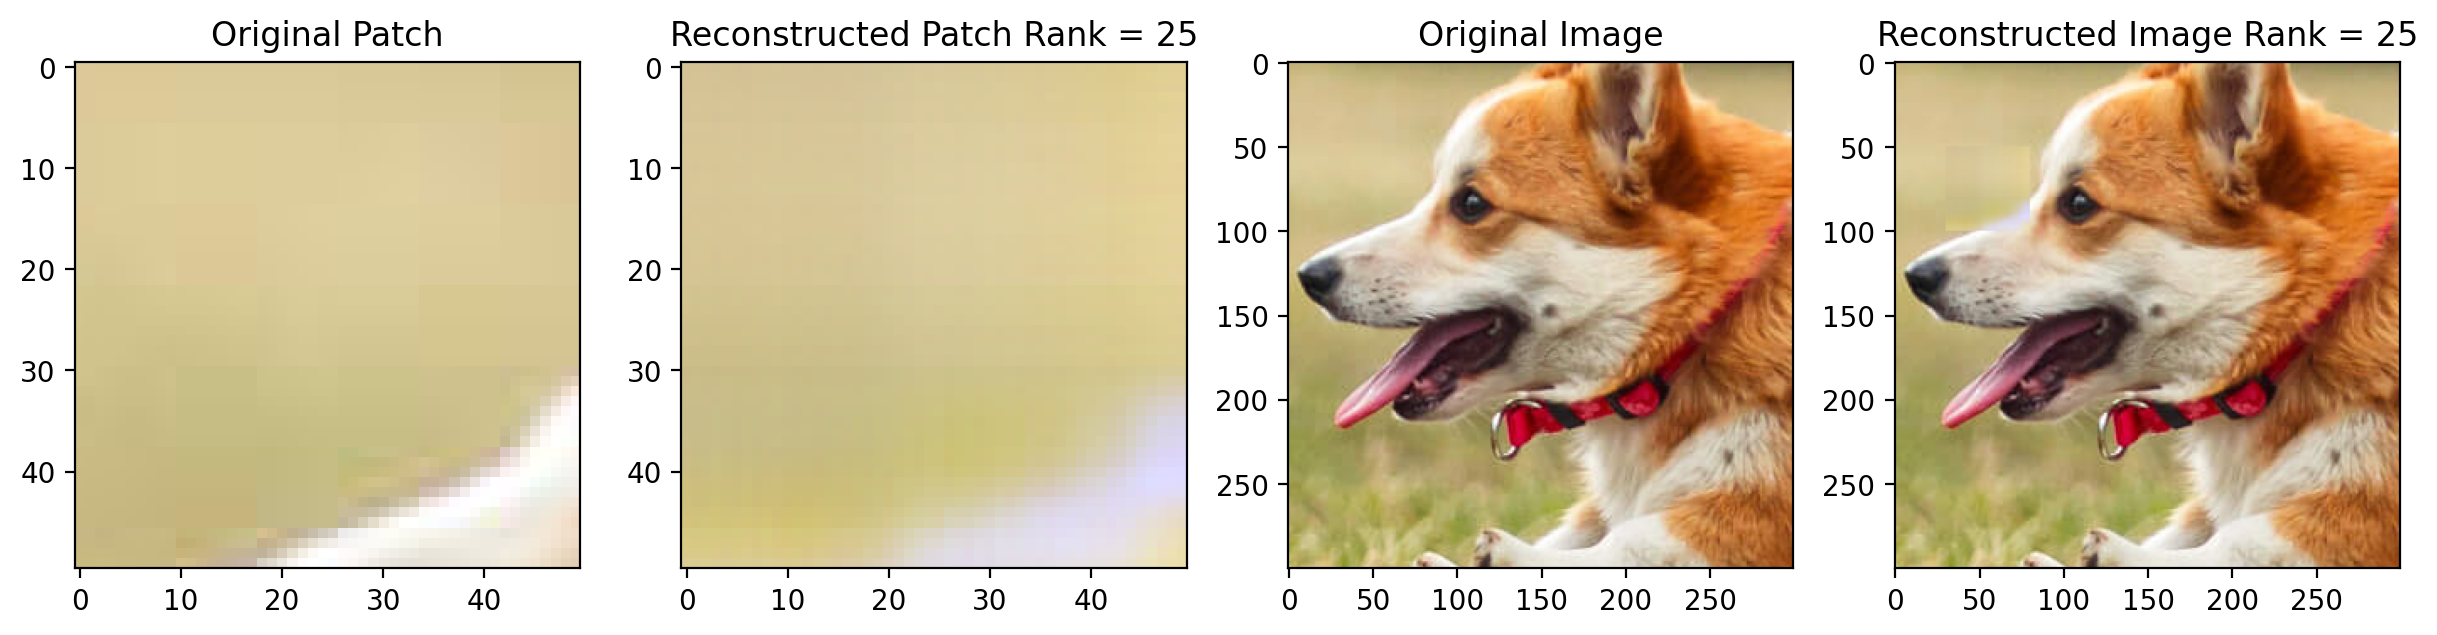

torch.Size([50, 50, 3]) torch.Size([50, 50, 3])


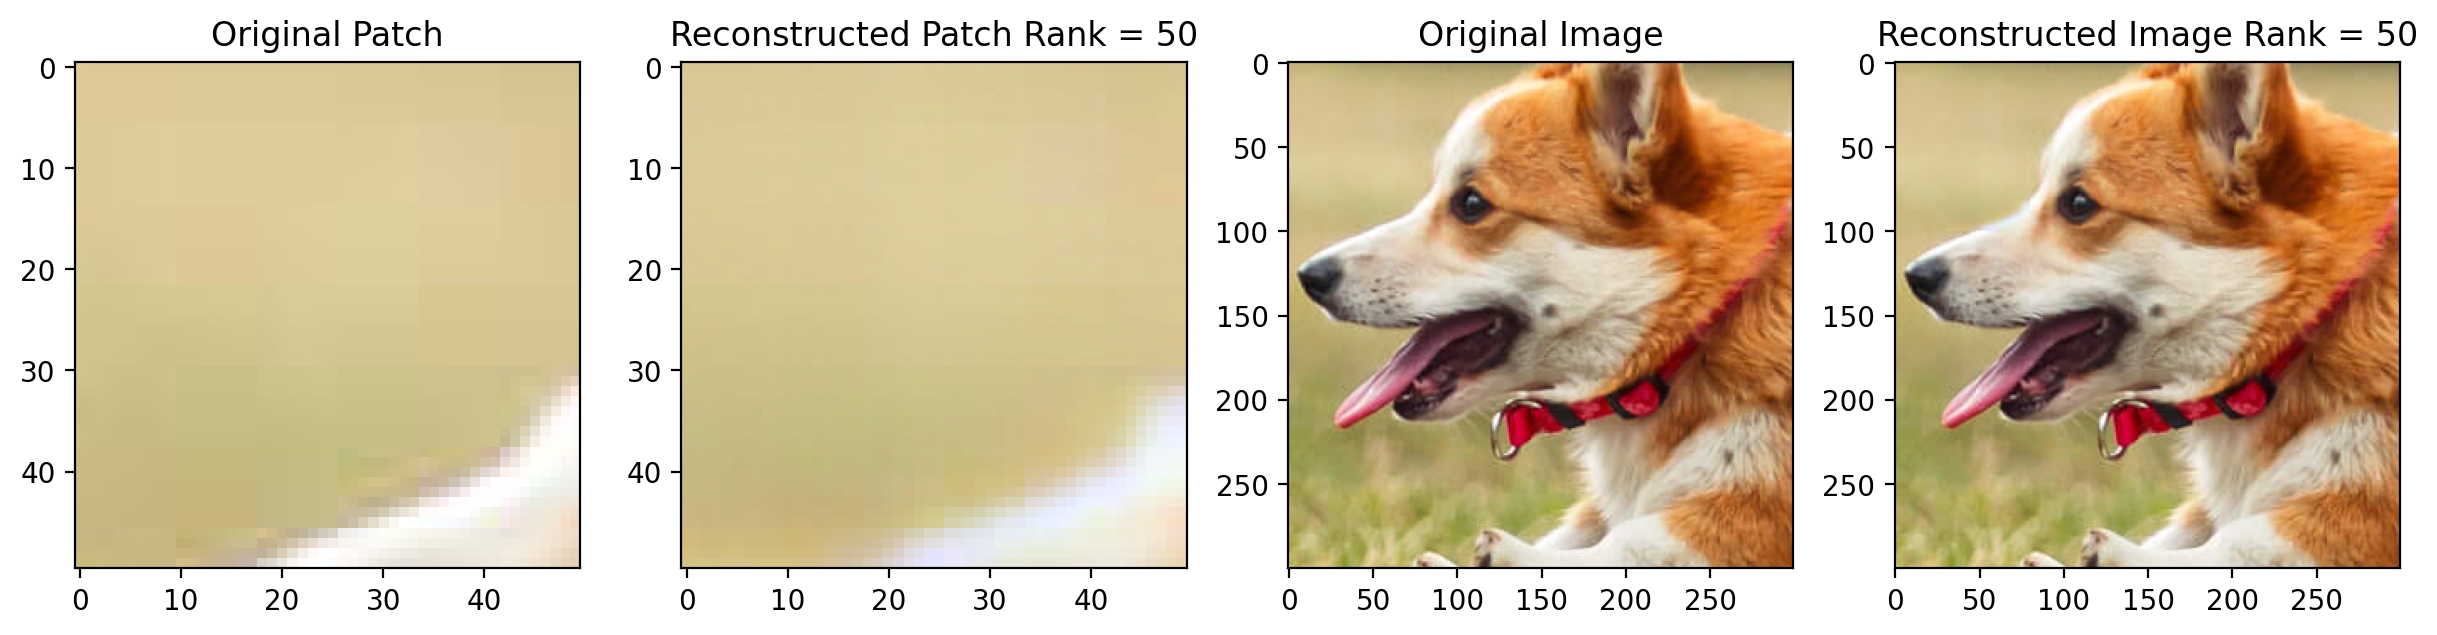

Rank: 5, RMSE: 15.41405005540822, PSNR: 24.372468309175765
Rank: 10, RMSE: 13.92483186159494, PSNR: 25.255004410790516
Rank: 25, RMSE: 8.96797817659958, PSNR: 29.0769127538585
Rank: 50, RMSE: 4.3486518941769345, PSNR: 35.36371072549814


In [9]:
params_patch_2 = get_data(2, [5,10,25,50], 2000)   
RMSE, PSNR = params_patch_2[3], params_patch_2[4]
for i in range(len(ranks)):
    print(f'Rank: {ranks[i]}, RMSE: {RMSE[i]}, PSNR: {PSNR[i]}')

## Patch 3 - Multi Colored Patch

Training for rank 5
Epoch 1/2000, Loss: 14238.0712890625
Epoch 101/2000, Loss: 11610.8916015625


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W, H, loss_arr = factorize(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), rank, epochs)


Epoch 201/2000, Loss: 6544.7958984375
Epoch 301/2000, Loss: 2676.849853515625
Epoch 401/2000, Loss: 1233.7364501953125
Epoch 501/2000, Loss: 931.8934936523438
Epoch 601/2000, Loss: 888.171875
Epoch 701/2000, Loss: 881.9257202148438
Epoch 801/2000, Loss: 880.0339965820312
Epoch 901/2000, Loss: 877.4366455078125
Epoch 1001/2000, Loss: 871.3152465820312
Epoch 1101/2000, Loss: 856.0742797851562
Epoch 1201/2000, Loss: 822.23681640625
Epoch 1301/2000, Loss: 764.6617431640625
Epoch 1401/2000, Loss: 693.2454223632812
Epoch 1501/2000, Loss: 625.2741088867188
Epoch 1601/2000, Loss: 573.7776489257812
Epoch 1701/2000, Loss: 538.0464477539062
Epoch 1801/2000, Loss: 509.8937072753906
Epoch 1901/2000, Loss: 483.9644470214844
----------------------------------------
Training for rank 10
Epoch 1/2000, Loss: 13964.46484375
Epoch 101/2000, Loss: 9206.60546875
Epoch 201/2000, Loss: 3063.2353515625
Epoch 301/2000, Loss: 1095.9322509765625
Epoch 401/2000, Loss: 893.6787719726562
Epoch 501/2000, Loss: 879.15

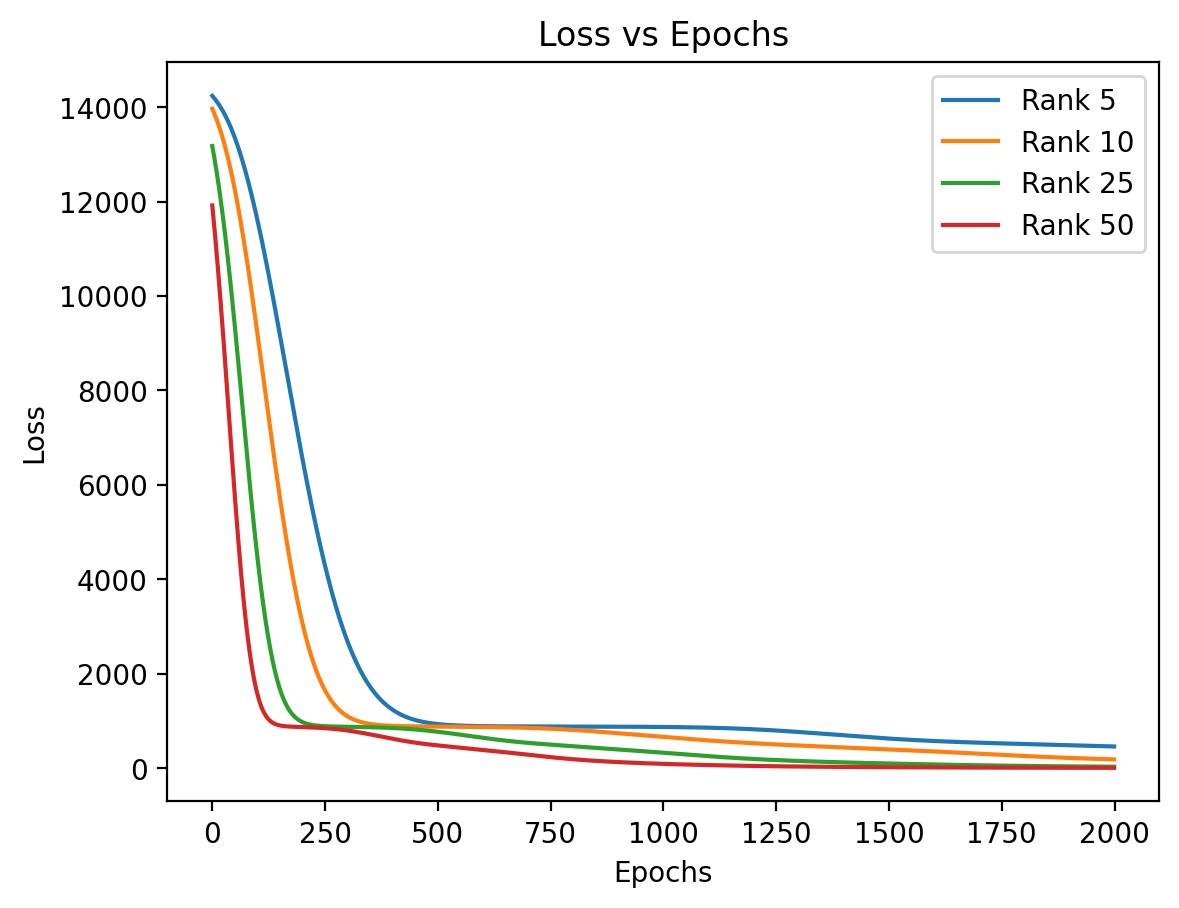

torch.Size([50, 5, 3]) torch.Size([5, 50, 3])


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  RMSE.append(rmse(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))
C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_26180\557503788.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PSNR.append(peak_snr(torch.tensor(patch_mapping[patch_number], dtype=torch.float32), reconstructed_image.permute(1, 2, 0)))


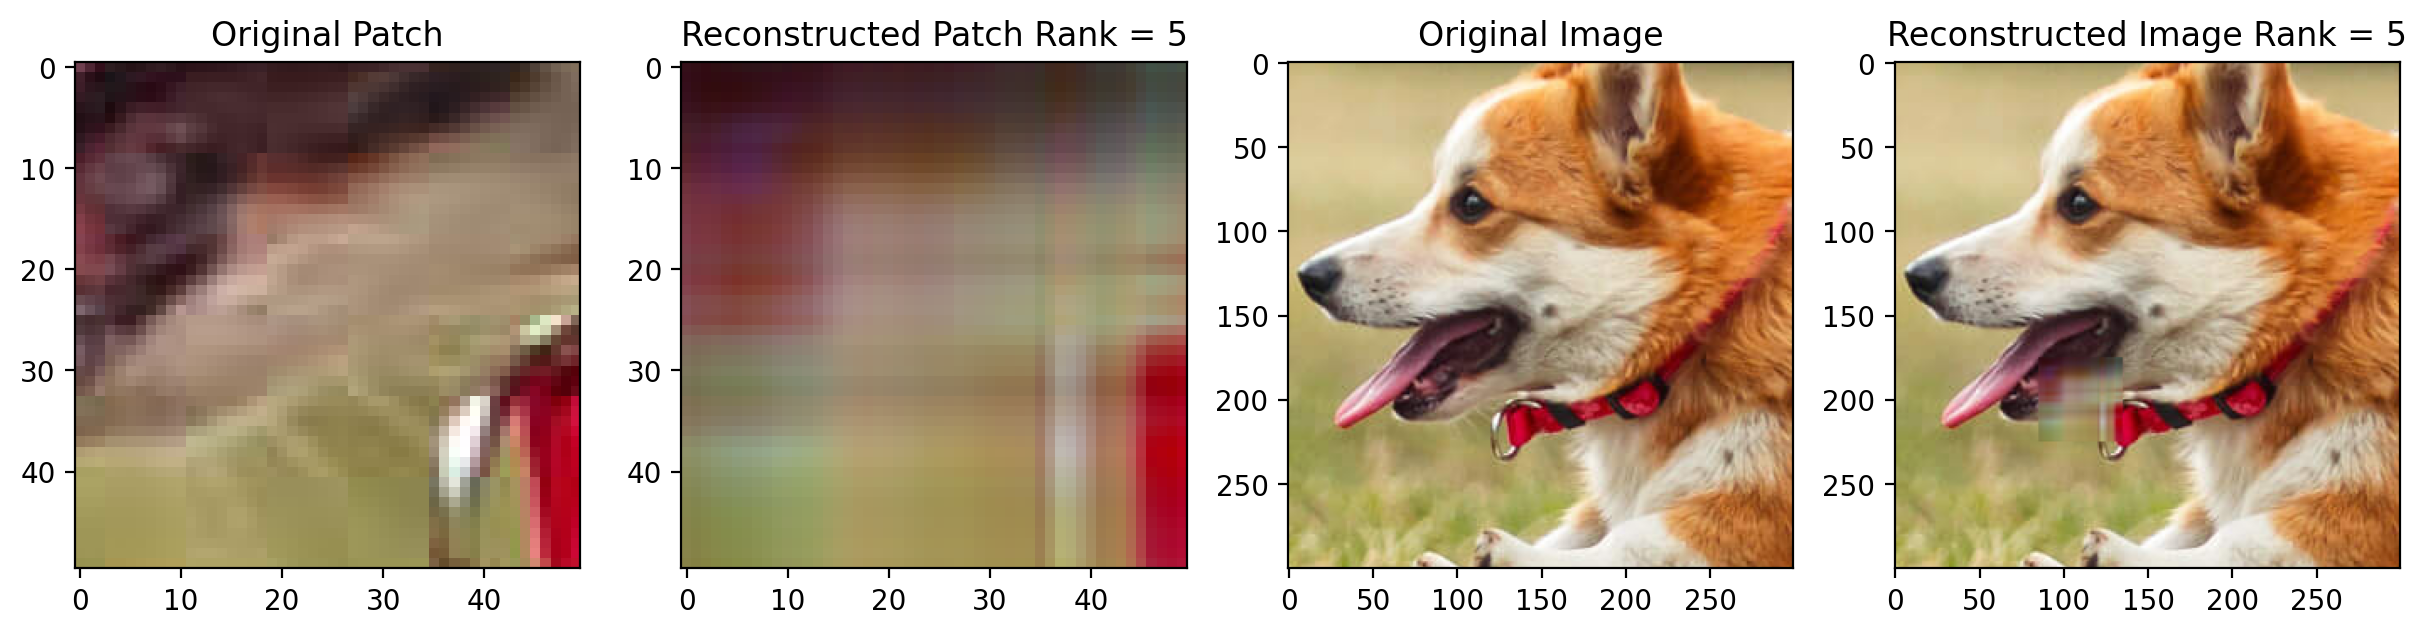

torch.Size([50, 10, 3]) torch.Size([10, 50, 3])


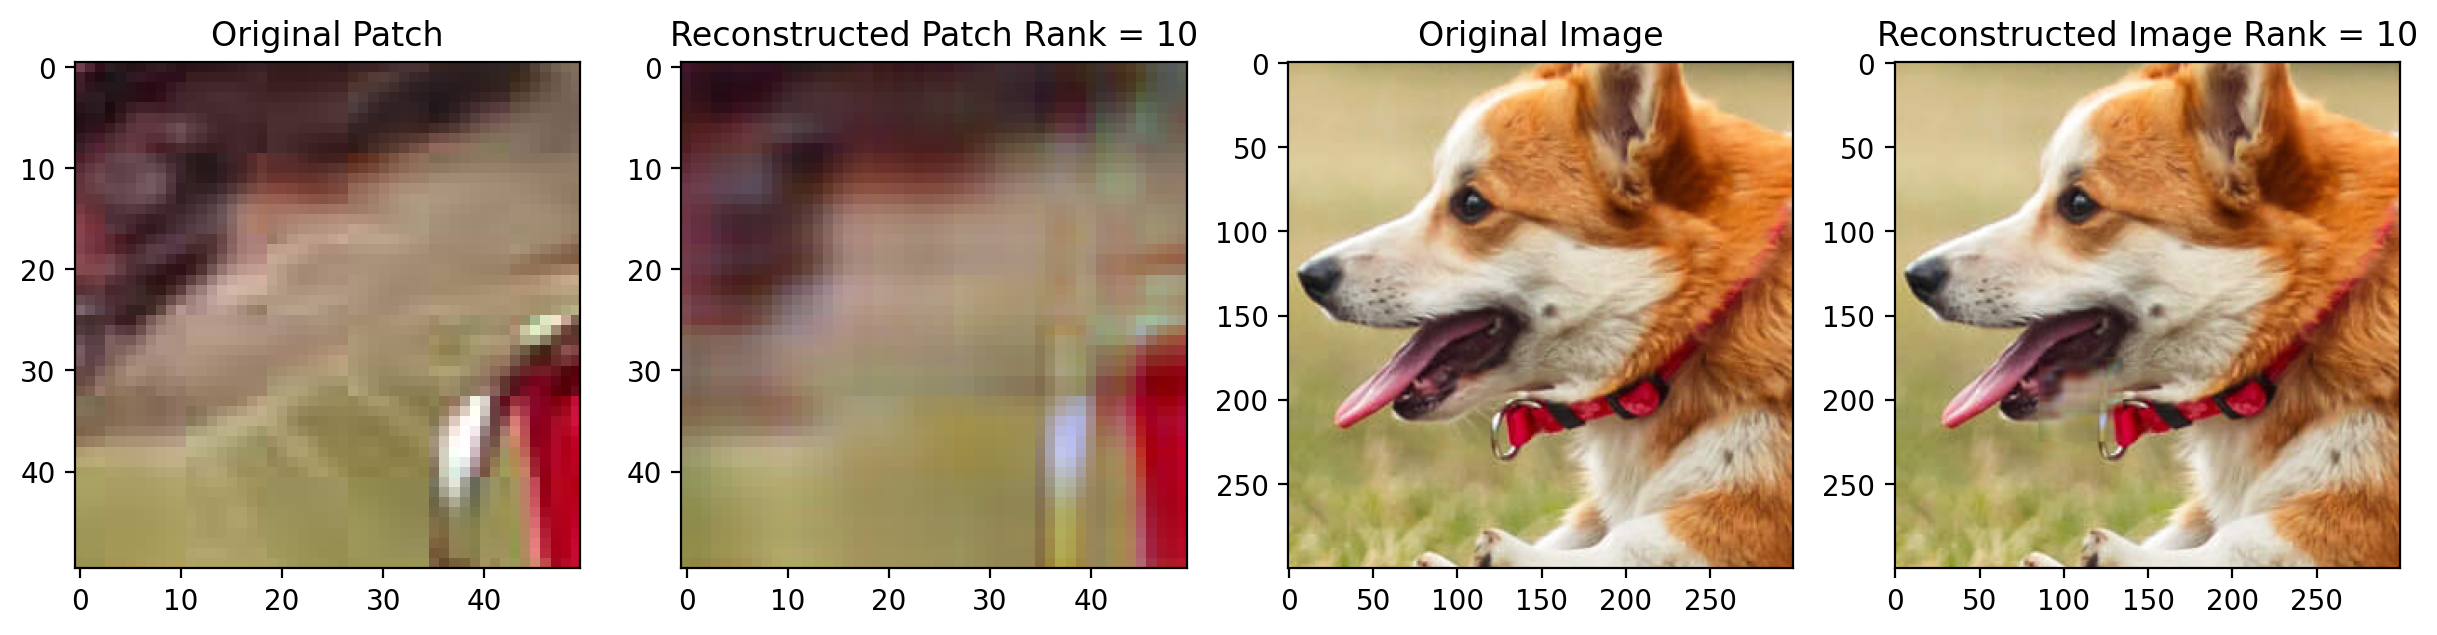

torch.Size([50, 25, 3]) torch.Size([25, 50, 3])


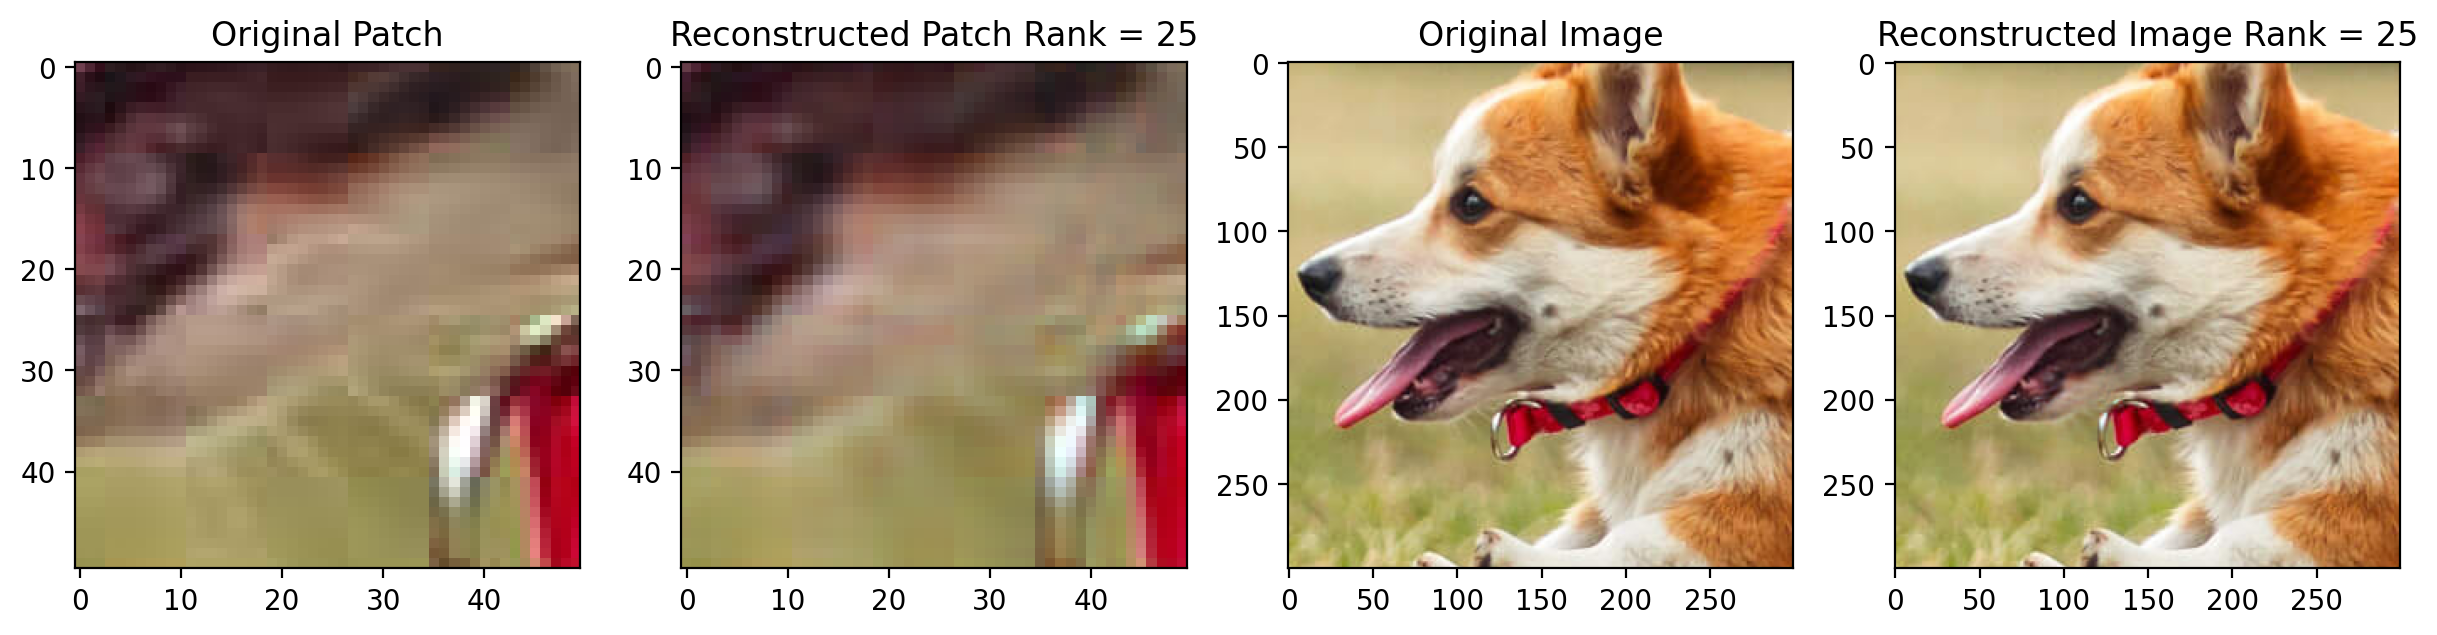

torch.Size([50, 50, 3]) torch.Size([50, 50, 3])


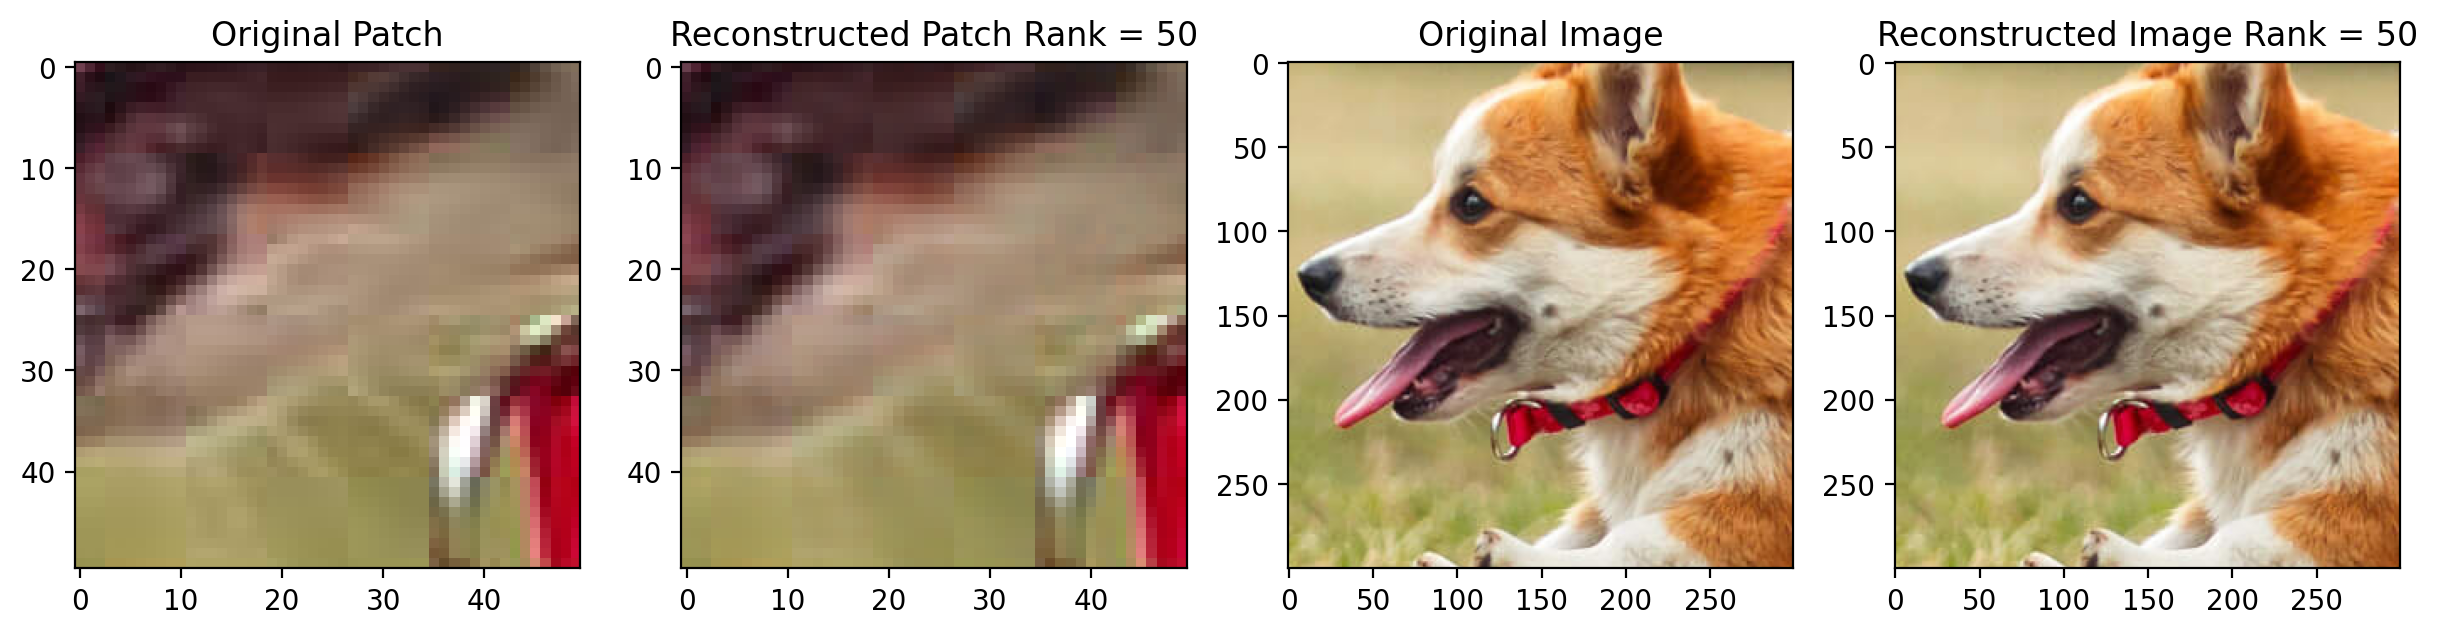

Rank: 5, RMSE: 21.394795724680257, PSNR: 21.524640723869393
Rank: 10, RMSE: 13.559177708879465, PSNR: 25.486136554525093
Rank: 25, RMSE: 5.413452570310638, PSNR: 33.46131688702225
Rank: 50, RMSE: 2.324547720459508, PSNR: 40.8040342845133


In [10]:
params_patch_3 = get_data(3, [5,10,25,50], 2000)
RMSE, PSNR = params_patch_3[3], params_patch_3[4]
for i in range(len(ranks)):
    print(f'Rank: {ranks[i]}, RMSE: {RMSE[i]}, PSNR: {PSNR[i]}')

## Inferences:

1. The Patch reconstruction algorithm can efficiently reconstruct image with less variation in colors with relatively low rank factorization. 
2. The reconstruction for patch with high variation in color typically require high rank